In [68]:
ls

a_exsrc10.png  a_exsrc9.png        Car_Detection.ipynb     Ppl_Blurred/
a_exsrc11.png  a_FINAL_RESULT.png  Contour_candidates.png  Ppl_cropImg/
a_exsrc1.png   b_ppl1.jpeg         contouring.png          Ppl_face/
a_exsrc2.png   b_ppl2.png          final_res.png           Ppl_faceBlurred/
a_exsrc3.png   b_ppl3.png          grayscaled_plate.png    Preprocess.png
a_exsrc4.png   b_ppl4.png          ML_BLURcar.ipynb        Rotated.png
a_exsrc5.png   b_ppl5.png          ML_BLURimg.ipynb        Start.png
a_exsrc6.png   b_ppl6.png          msc.png                 z_FINALFINAL.png
a_exsrc7.png   Car_Blurred/        Plate_Contour.png       z_FINAL_RESULT.png
a_exsrc8.png   Car_cropImg/        Possible_contours.png


In [69]:
cd /content/drive/MyDrive/ml_pjct1

/content/drive/MyDrive/ml_pjct1


In [70]:
ls

a_exsrc10.png  a_exsrc9.png        Car_Detection.ipynb     Ppl_Blurred/
a_exsrc11.png  a_FINAL_RESULT.png  Contour_candidates.png  Ppl_cropImg/
a_exsrc1.png   b_ppl1.jpeg         contouring.png          Ppl_face/
a_exsrc2.png   b_ppl2.png          final_res.png           Ppl_faceBlurred/
a_exsrc3.png   b_ppl3.png          grayscaled_plate.png    Preprocess.png
a_exsrc4.png   b_ppl4.png          ML_BLURcar.ipynb        Rotated.png
a_exsrc5.png   b_ppl5.png          ML_BLURimg.ipynb        Start.png
a_exsrc6.png   b_ppl6.png          msc.png                 z_FINALFINAL.png
a_exsrc7.png   Car_Blurred/        Plate_Contour.png       z_FINAL_RESULT.png
a_exsrc8.png   Car_cropImg/        Possible_contours.png


In [71]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [72]:
!sudo apt install tesseract-ocr-kor
!pip install pytesseract
!pip install Pillow==9.0.0
import pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr-kor is already the newest version (4.00~git24-0e00fe6-1.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 62 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


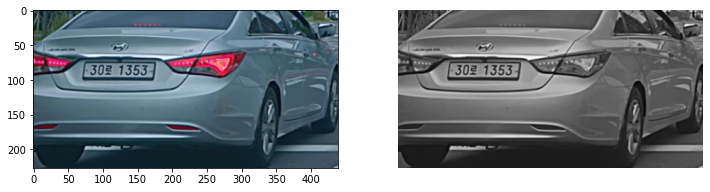

In [73]:
img = cv2.imread('a_exsrc4.png')
orig_img = img.copy()
height, width, channel = img.shape
imgray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12,8))
plt.subplot(121),plt.imshow(img[:,:,::-1],'gray')
plt.subplot(122),plt.imshow(imgray,'gray')
plt.axis('off')
plt.savefig("Start")
plt.show()

<Figure size 1440x1440 with 0 Axes>

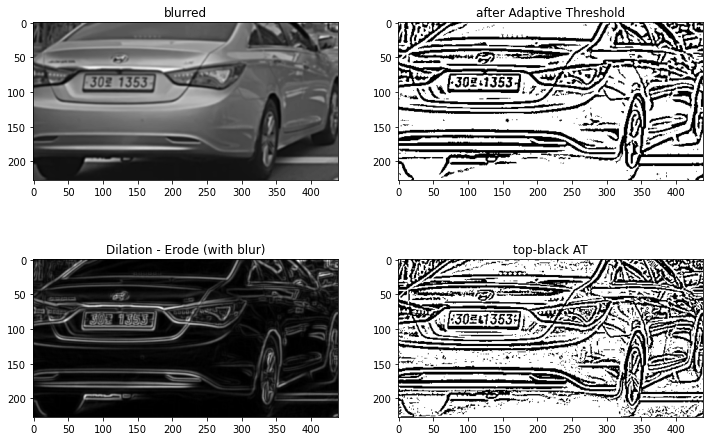

In [74]:
# Edge를 뚜렷하게 하기 위해 가우시안 블러 적용
blur = cv2.GaussianBlur(imgray,(5,5),0)

# Adaptive Threshold 적용
thr = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
plt.figure(figsize=(20,20))

# dilation - erode with / without blur 
kernel = np.ones((3,3),np.uint8)
dil = cv2.dilate(blur,kernel,iterations=1)
ero = cv2.erode(blur,kernel,iterations=1)
morph = dil - ero

kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

topHat = cv2.morphologyEx(imgray, cv2.MORPH_TOPHAT, kernel2)
blackHat = cv2.morphologyEx(imgray, cv2.MORPH_BLACKHAT, kernel2)

imgGrayscalePlusTopHat = cv2.add(imgray, topHat)
subtract = cv2.subtract(imgGrayscalePlusTopHat, blackHat)
thr2 = cv2.adaptiveThreshold(subtract,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                             cv2.THRESH_BINARY,11,2)
plt.figure(figsize=(12,8))
plt.subplot(221), plt.imshow(blur,'gray')
plt.title("blurred")
plt.subplot(222), plt.imshow(thr,'gray')
plt.title("after Adaptive Threshold")
plt.subplot(223), plt.imshow(morph,'gray')
plt.title("Dilation - Erode (with blur)")
plt.subplot(224), plt.imshow(thr2,'gray')
plt.title("top-black AT")
plt.savefig("Preprocess")
plt.show()

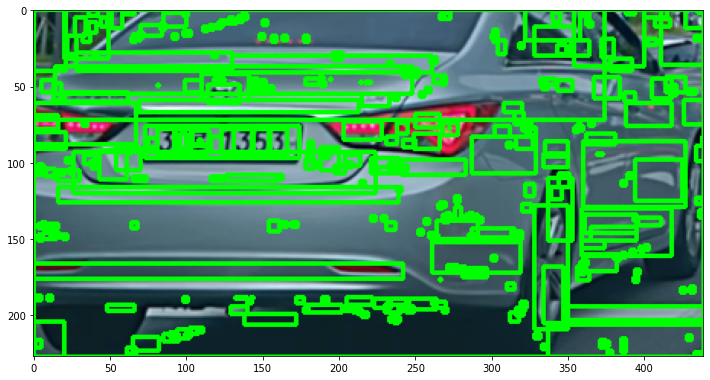

In [75]:
# canny 하지 않고
# 그냥 Adaptive Thresh가 젤 잘나옴 
orig_img = img.copy()
cnts,contours = cv2.findContours(thr,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[1], cv2.findContours(thr,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)[0]
contours_dict = []
pos_cnt = list()
box1 = list()

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(orig_img, pt1=(x, y), pt2=(x+w, y+h), color=(0, 255, 0), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12,8))         
plt.imshow(orig_img[:,:,::-1])   
plt.savefig("Contour_candidates")
plt.show()    

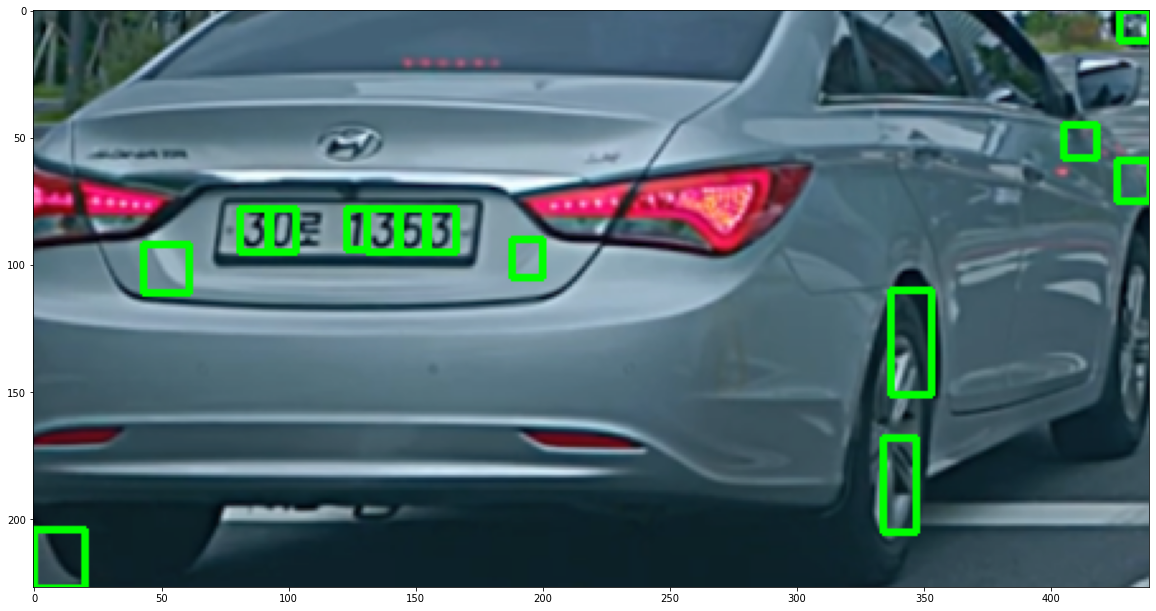

In [76]:
orig_img = img.copy()
count = 0

for d in contours_dict:
    rect_area = d['w']*d['h'] # 영역 크기
    aspect_ratio = d['w'] / d['h']
    
    if (aspect_ratio >= 0.3) and (aspect_ratio <= 1.0) and (rect_area >= 100) and (rect_area <= 800):
        cv2.rectangle(orig_img,(d['x'],d['y']),(d['x']+d['w'],d['y']+d['h']),(0,255,0),2)
        d['idx'] = count
        count += 1
        pos_cnt.append(d)
        

plt.figure(figsize=(20,20))         
plt.imshow(orig_img[:,:,::-1])
plt.savefig("Possible_contours")
plt.show()

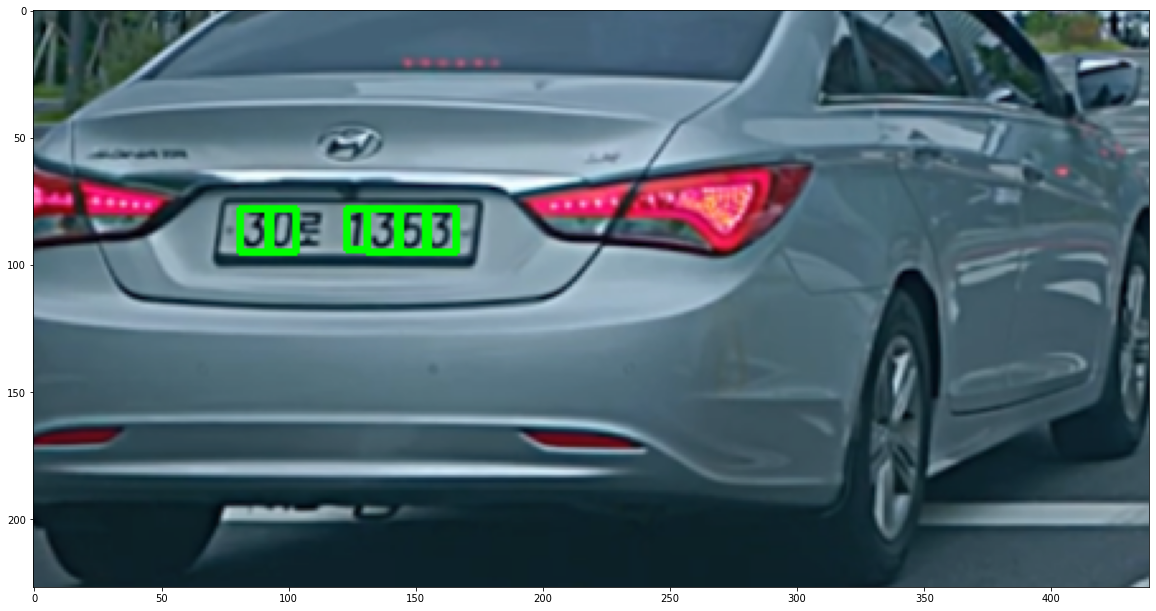

In [ ]:
MAX_DIAG_MULTIPLYER = 5 # contourArea의 대각선 x5 안에 다음 contour가 있어야함
MAX_ANGLE_DIFF = 12.0  # contour와 contour 중심을 기준으로 한 각도가 n 이내여야함
MAX_AREA_DIFF = 0.5 # contour간에 면적 차이가 크면 인정하지 않겠다.
MAX_WIDTH_DIFF = 0.8 # contour간에 너비 차이가 크면 인정 x
MAX_HEIGHT_DIFF = 0.2 # contour간에 높이 차이가 크면 인정 x
MIN_N_MATCHED = 3 # 위의 조건을 따르는 contour가 최소 3개 이상이어야 번호판으로 인정
orig_img = img.copy()
def find_number(contour_list):
    matched_result_idx = []
    
    # contour_list[n]의 keys = dict_keys(['contour', 'x', 'y', 'w', 'h', 'cx', 'cy', 'idx'])
    for d1 in contour_list:
        matched_contour_idx = []
        for d2 in contour_list:      # for문을 2번 돌면서 contour끼리 비교해줄 것
            if d1['idx'] == d2['idx']:   # idx가 같다면 아예 동일한 contour이기에 패스
                continue
                
            dx = abs(d1['cx']-d2['cx'])  # d1, d2 중앙점 기준으로 x축의 거리
            dy = abs(d1['cy']-d2['cy'])  # d1, d2 중앙점 기준으로 y축의 거리
            # 이를 구한 이유는 대각 길이를 구하기 위함 / 피타고라스 정리
            
            # 기준 Contour 사각형의 대각선 길이 구하기
            diag_len = np.sqrt(d1['w']**2+d1['w']**2)
            
            # contour 중심간의 대각 거리
            distance = np.linalg.norm(np.array([d1['cx'],d1['cy']]) - np.array([d2['cx'],d2['cy']]))
            
            # 각도 구하기
            # 빗변을 구할 때, dx와 dy를 알기에 tan세타 = dy / dx 로 구할 수 있다. 
            # 여기서 역함수를 사용하면    세타 =  arctan dy/dx 가 된다.
            if dx == 0:
                angle_diff = 90   # x축의 차이가 없다는 것은 다른 contour가 위/아래에 위치한다는 것
            else:
                angle_diff = np.degrees(np.arctan(dy/dx))  # 라디안 값을 도로 바꾼다. 
            
            # 면적의 비율 (기준 contour 대비)
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w']*d1['h'])
            # 너비의 비율
            width_diff = abs(d1['w']-d2['w']) / d1['w']
            # 높이의 비율
            height_diff = abs(d1['h']-d2['h']) / d2['h']    
                
            # 이제 조건에 맞는 idx만을 matched_contours_idx에 append할 것이다.
            if distance < diag_len * MAX_DIAG_MULTIPLYER and angle_diff < MAX_ANGLE_DIFF \
            and area_diff < MAX_AREA_DIFF and width_diff < MAX_WIDTH_DIFF \
            and height_diff < MAX_HEIGHT_DIFF:
                # 계속 d2를 번갈아 가며 비교했기에 지금 d2 넣어주고
                matched_contour_idx.append(d2['idx'])
                
        # d1은 기준이었으니 이제 append
        matched_contour_idx.append(d1['idx'])
        
        # 앞서 정한 후보군의 갯수보다 적으면 탈락
        if len(matched_contour_idx) < MIN_N_MATCHED:
            continue
        
        # 최종 contour를 입력
        matched_result_idx.append(matched_contour_idx)
        
        # 최종에 들지 못한 아닌애들도 한 번 더 비교
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contour_idx:
                unmatched_contour_idx.append(d4['idx'])
        
        # np.take(a,idx)   a배열에서 idx를 뽑아냄
        unmatched_contour = np.take(pos_cnt,unmatched_contour_idx)
        
        # 재귀적으로 한 번 더 돌림
        recursive_contour_list = find_number(unmatched_contour)
        
        # 최종 리스트에 추가
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
            
        break
        
    return matched_result_idx

result_idx = find_number(pos_cnt)

matched_result = []

for idx_list in result_idx:
    matched_result.append(np.take(pos_cnt,idx_list))
    
# pos_cnt 시각화

for r in matched_result:
    for d in r:
        cv2.rectangle(orig_img,(d['x'],d['y']),(d['x']+d['w'],d['y']+d['h']),(0,255,0),2)
        
plt.figure(figsize=(20,20))        
plt.imshow(orig_img[:,:,::-1])
plt.savefig("Plate_Contour")
plt.show()

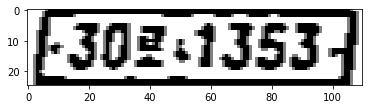

In [ ]:
PLATE_WIDTH_PADDING = 1.3 
PLATE_HEIGHT_PADDING = 1.5 
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    # 합집합 구하는 것 처럼 교집합([0]['x']) 제거 
    # 그리고 패딩
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']
        
    # 평균 구하고 패딩
    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    # 삐뚫어져있기에 각도를 구해야함 
    
    # 높이는 알고 빗변도 알기에 세타를 구할 수 있음 (기울어진 정도)
    
    # 높이
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    # 빗변
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    # arcsin을 이용함 
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    rotation_matrix = cv2.getRotationMatrix2D((plate_cx, plate_cy), angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(thr, M=rotation_matrix, dsize=(width, height))
    
    # 원하는 부분만 잘라냄
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    # h/w < Min   or   Max < h/w < Min  해당하면 패스  해당하지 않을경우 append
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or \
    img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.savefig("grayscaled_plate")
    plt.imshow(img_cropped, cmap='gray')

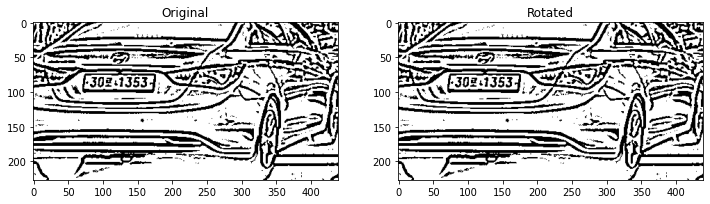

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121), plt.imshow(thr,'gray'), plt.title("Original")
plt.subplot(122), plt.imshow(img_rotated,'gray'), plt.title("Rotated")
plt.savefig("Rotated")
plt.show()

0
13021353


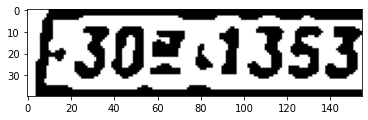

In [ ]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.2, 1.0

longest_idx, longest_text = -1, 0
plate_chars = []

cnt = 0

for i, plate_img in enumerate(plate_imgs):
    print(cnt)
    cnt = cnt + 1
    
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # 위와 같이 contours 다시 찾기
    _, contours = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)[1], cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)[0]
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    # 한번더 blur, threshold
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7')
    
    result_chars = ''
    has_digit = False
    for c in chars:
        if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
            if c.isdigit():
                has_digit = True
            result_chars += c
    
    print(result_chars)
    plate_chars.append(result_chars)

    if has_digit and len(result_chars) > longest_text:
        longest_idx = i

    plt.subplot(len(plate_imgs), 1, i+1)
    plt.imshow(img_result, cmap='gray')

13021353


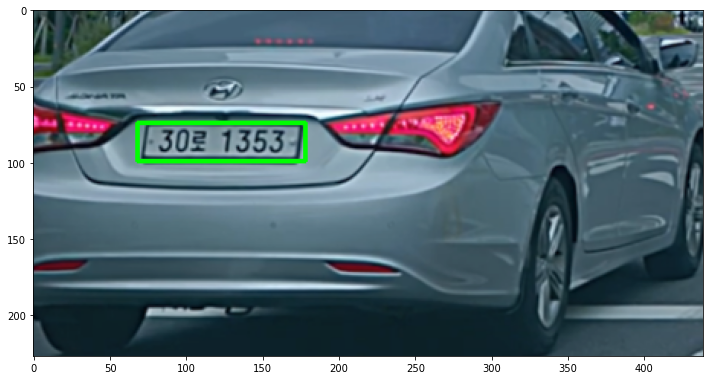

In [ ]:
info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

orig_img = img.copy()

cv2.rectangle(orig_img, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(0,255,0), thickness=2)

cv2.imwrite('./res/' +chars[:7] + '.jpg', orig_img)

plt.figure(figsize=(12, 10))
plt.imshow(orig_img[:,:,::-1])

13021353


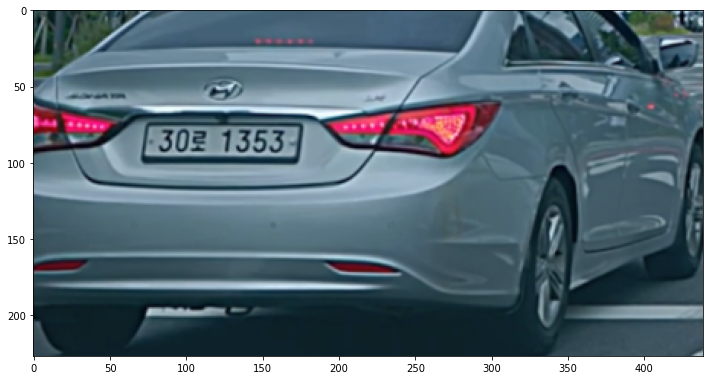

In [ ]:
info = plate_infos[longest_idx]
chars = plate_chars[longest_idx]

print(chars)

orig_img2 = img.copy()

# boundingRect 표시!
# cv2.rectangle(orig_img, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(0,255,0), thickness=2)

cv2.imwrite('./res/' +chars[:7] + '.jpg', orig_img)

plt.figure(figsize=(12, 10))
plt.imshow(orig_img2[:,:,::-1])
plt.savefig("contouring")

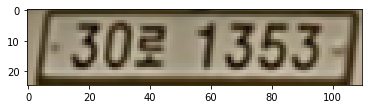

In [ ]:
# 원본 이미지에서 번호판 영역을 추출합니다
img_m = orig_img2[info['y']:info['y']+info['h'],info['x']:info['x']+info['w']]
plt.imshow(img_m)
plt.show()

(5, 22, 3)


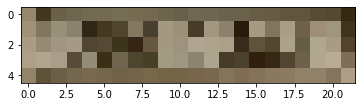

In [ ]:
# 1. 사각영역을 먼저 골라낸 후
# 2. 잘라낸 이미지의 크기를 축소한다
# 3. 다시 크기를 확대하여 원본 이미지를 대체한다.

img_m_resize = cv2.resize(img_m,(0,0),fx=0.2,fy=0.2)
plt.imshow(img_m_resize)
print(img_m_resize.shape)

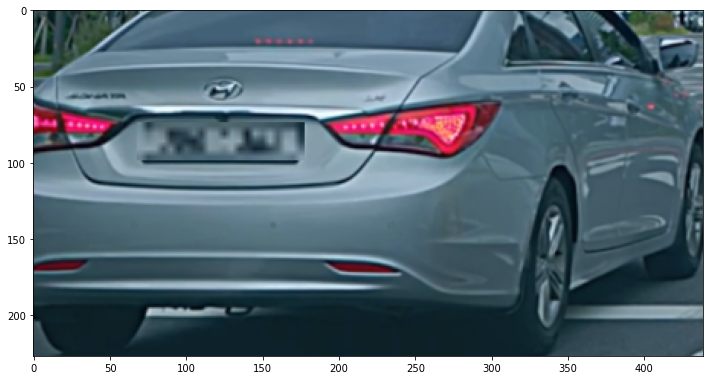

In [ ]:
h,w,_ = img_m.shape
orig_img2 = img.copy()
img_m_resize = cv2.resize(img_m_resize,(w,h))
orig_img2[info['y']:info['y']+info['h'],info['x']:info['x']+info['w']] = img_m_resize
plt.figure(figsize=(12,8))
plt.imshow(orig_img2[:,:,::-1])
plt.savefig("final_res")
plt.show()